# Notebook for analysing and reviewing experiment results

In [6]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Testing Prior to Fine Tuning

In [2]:
import model_helper as mh
import data_helper_v2 as dh

model = mh.get_model(ts_encoder_config={"name": 'LSTM'}, text_encoder_config={"name": 'bert-base-uncased', "auto-pre-trained": True},
                      projection_dim=64, ts_window=5)
    
df = dh._helper_generate_synthetic_benchmark(model=model)

df["label"] = df['label'].replace(0, -1)


c:\Users\eoinp\anaconda3\envs\deepl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\eoinp\anaconda3\envs\deepl\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\eoinp\anaconda3\envs\deepl\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from tqdm import tqdm
import numpy as np
df["cosine_similarity"] = None


text_tokenizer = model.get_text_tokenizer()
prior_to_train_dataset = dh.CustomDataset(df, text_tokenizer=text_tokenizer)

dataloader = DataLoader(prior_to_train_dataset, batch_size=32, shuffle=False)
device = 'cpu'
model.eval()

all_preds = []

with torch.no_grad():
    for ts_data, text_data, attention_mask, labels in tqdm(dataloader, leave=True, position=1):
        ts_data = ts_data.to(device)
        text_data = text_data.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        ts_embeddings, text_embeddings = model(ts_data, text_data, attention_mask)



        preds = model.predict(ts_data=ts_data, input_ids=text_data, attention_mask=attention_mask)#TODO same as train loop, check it works with the batch of embeddings
        all_preds.extend(preds)

all_preds = np.array(all_preds) #convert to numpy array
df["cosine_similarity"] = all_preds

df_positives = df.loc[df["label"] == 1]
df_negatives = df.loc[df["label"] == -1]

100%|██████████| 94/94 [01:16<00:00,  1.22it/s]


In [3]:
df_positives

id ticker                 Start Date  \
0        0   APPL 2024-08-14 23:13:20.863736   
2        2   APPL 2024-08-12 23:13:20.863736   
3        3   APPL 2024-08-11 23:13:20.863736   
5        5   APPL 2024-08-09 23:13:20.863736   
6        6   APPL 2024-08-08 23:13:20.863736   
...    ...    ...                        ...   
2991  2991   MSFN 2023-04-11 23:13:20.863736   
2994  2994   MSFN 2023-04-08 23:13:20.863736   
2995  2995   MSFN 2023-04-07 23:13:20.863736   
2996  2996   MSFN 2023-04-06 23:13:20.863736   
2999  2999   MSFN 2023-04-03 23:13:20.863736   

                                     text                     time_series  \
0     decline decrease drop negative loss  [[51], [50], [49], [48], [47]]   
2     negative decrease drop loss decline  [[78], [77], [76], [75], [74]]   
3      growth positive gain rise increase  [[67], [68], [69], [70], [71]]   
5     drop decrease decline negative loss  [[57], [56], [55], [54], [53]]   
6      positive gain growth increase rise  [[75], [76], [77], [78], [79]]   
...                                   ...                             ...   
2991   gain growth rise increase positive  [[82], [83], [84], [85], [86]]   
2994  decline decrease negative loss drop  [[97], [96], [95], [94], [93]]   
2995   rise positive increase growth gain  [[88], [89], [90], [91], [92]]   
2996   positive gain growth increase rise  [[91], [92], [93], [94], [95]]   
2999  negative decrease decline loss drop  [[57], [56], [55], [54], [53]]   

      label  cosine_similarity  
0         1          -0.047213  
2         1          -0.125635  
3         1          -0.108888  
5         1          -0.071609  
6         1          -0.102501  
...     ...                ...  
2991      1          -0.101563  
2994      1          -0.081359  
2995      1          -0.088990  
2996      1          -0.107800  
2999      1          -0.087570  

[1518 rows x 7 columns]

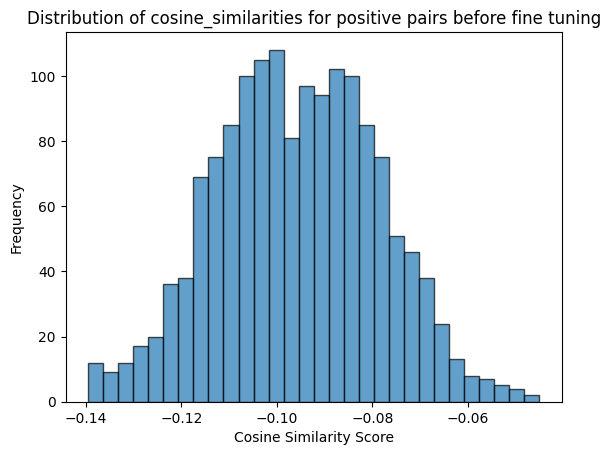

id ticker                 Start Date  \
0        0   APPL 2024-08-14 23:13:20.863736   
2        2   APPL 2024-08-12 23:13:20.863736   
3        3   APPL 2024-08-11 23:13:20.863736   
5        5   APPL 2024-08-09 23:13:20.863736   
6        6   APPL 2024-08-08 23:13:20.863736   
...    ...    ...                        ...   
2991  2991   MSFN 2023-04-11 23:13:20.863736   
2994  2994   MSFN 2023-04-08 23:13:20.863736   
2995  2995   MSFN 2023-04-07 23:13:20.863736   
2996  2996   MSFN 2023-04-06 23:13:20.863736   
2999  2999   MSFN 2023-04-03 23:13:20.863736   

                                     text                     time_series  \
0     decline decrease drop negative loss  [[51], [50], [49], [48], [47]]   
2     negative decrease drop loss decline  [[78], [77], [76], [75], [74]]   
3      growth positive gain rise increase  [[67], [68], [69], [70], [71]]   
5     drop decrease decline negative loss  [[57], [56], [55], [54], [53]]   
6      positive gain growth increase rise  [[75], [76], [77], [78], [79]]   
...                                   ...                             ...   
2991   gain growth rise increase positive  [[82], [83], [84], [85], [86]]   
2994  decline decrease negative loss drop  [[97], [96], [95], [94], [93]]   
2995   rise positive increase growth gain  [[88], [89], [90], [91], [92]]   
2996   positive gain growth increase rise  [[91], [92], [93], [94], [95]]   
2999  negative decrease decline loss drop  [[57], [56], [55], [54], [53]]   

      label  cosine_similarity  
0         1          -0.047213  
2         1          -0.125635  
3         1          -0.108888  
5         1          -0.071609  
6         1          -0.102501  
...     ...                ...  
2991      1          -0.101563  
2994      1          -0.081359  
2995      1          -0.088990  
2996      1          -0.107800  
2999      1          -0.087570  

[1518 rows x 7 columns]

In [4]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'column_name' is the column you want to plot
df_positives['cosine_similarity'].plot(kind='hist', bins=30, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of cosine_similarities for positive pairs before fine tuning')

# Show the plot
plt.show()

df_positives

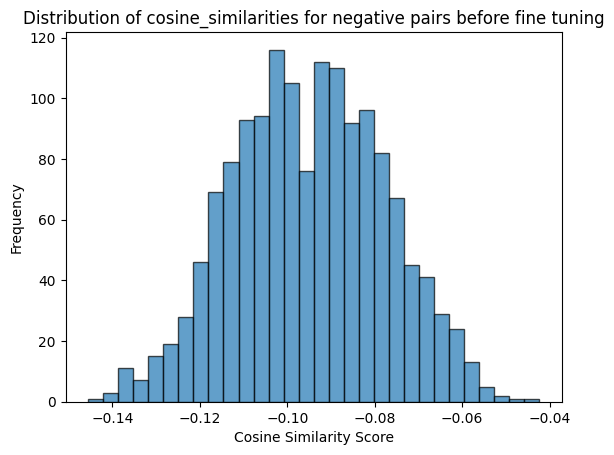

id ticker                 Start Date  \
1        1   APPL 2024-08-13 23:13:20.863736   
4        4   APPL 2024-08-10 23:13:20.863736   
7        7   APPL 2024-08-07 23:13:20.863736   
8        8   APPL 2024-08-06 23:13:20.863736   
9        9   APPL 2024-08-05 23:13:20.863736   
...    ...    ...                        ...   
2989  2989   MSFN 2023-04-13 23:13:20.863736   
2992  2992   MSFN 2023-04-10 23:13:20.863736   
2993  2993   MSFN 2023-04-09 23:13:20.863736   
2997  2997   MSFN 2023-04-05 23:13:20.863736   
2998  2998   MSFN 2023-04-04 23:13:20.863736   

                                     text                     time_series  \
1     decline loss decrease negative drop  [[53], [54], [55], [56], [57]]   
4     loss decrease decline negative drop  [[76], [77], [78], [79], [80]]   
7     decrease drop negative loss decline  [[66], [67], [68], [69], [70]]   
8     decline decrease loss negative drop  [[87], [88], [89], [90], [91]]   
9      gain rise growth increase positive  [[57], [56], [55], [54], [53]]   
...                                   ...                             ...   
2989   growth increase positive gain rise  [[67], [66], [65], [64], [63]]   
2992  negative loss decline decrease drop  [[91], [92], [93], [94], [95]]   
2993   positive growth increase gain rise  [[93], [92], [91], [90], [89]]   
2997   gain positive increase growth rise  [[86], [85], [84], [83], [82]]   
2998   rise increase positive growth gain  [[99], [98], [97], [96], [95]]   

      label  cosine_similarity  
1        -1          -0.088750  
4        -1          -0.063986  
7        -1          -0.102987  
8        -1          -0.074792  
9        -1          -0.079814  
...     ...                ...  
2989     -1          -0.089677  
2992     -1          -0.103863  
2993     -1          -0.115689  
2997     -1          -0.082992  
2998     -1          -0.093380  

[1482 rows x 7 columns]

In [5]:
df_negatives['cosine_similarity'].plot(kind='hist', bins=30, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of cosine_similarities for negative pairs before fine tuning')

# Show the plot
plt.show()
df_negatives

In [42]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.CosineEmbeddingLoss(margin=0.0, size_average=None, reduce=None, reduction='mean')
mh.train(model=model, train_loader=dataloader, optimizer=optimizer , device='cpu', criterion=criterion)

100%|██████████| 94/94 [08:48<00:00,  5.62s/it]


(0.5110882961369575,
 0.5086666666666667,
 0.38307414889032537,
 array([[  79, 1403],
        [  71, 1447]], dtype=int64))

In [43]:
#df["cosine_similarity"] = None

model.eval()

after_one_epoch_all_preds = []

with torch.no_grad():
    for ts_data, text_data, attention_mask, labels in tqdm(dataloader, leave=True, position=1):
        ts_data = ts_data.to(device)
        text_data = text_data.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        ts_embeddings, text_embeddings = model(ts_data, text_data, attention_mask)



        preds = model.predict(ts_data=ts_data, input_ids=text_data, attention_mask=attention_mask)#TODO same as train loop, check it works with the batch of embeddings
        after_one_epoch_all_preds.extend(preds)

after_one_epoch_all_preds = np.array(after_one_epoch_all_preds) #convert to numpy array
df["cosine_similarity"] = after_one_epoch_all_preds

after_one_epoch_all_preds_df_positives = df.loc[df["label"] == 1]
after_one_epoch_all_preds_df_negatives = df.loc[df["label"] == -1]

 17%|█▋        | 16/94 [00:22<01:49,  1.40s/it]


KeyboardInterrupt: 

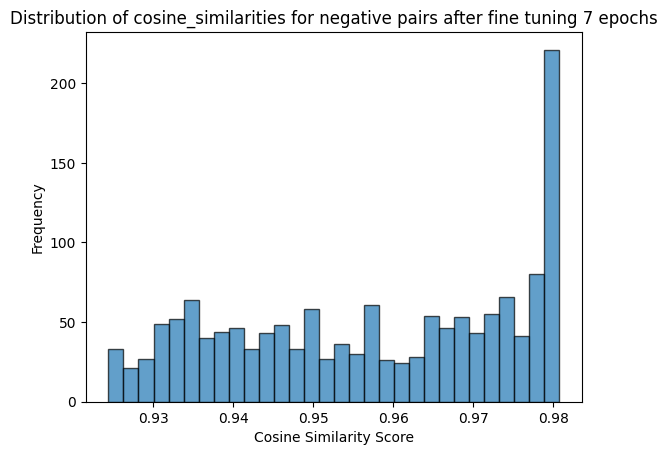

id ticker                 Start Date  \
1        1   APPL 2024-08-13 23:13:20.863736   
4        4   APPL 2024-08-10 23:13:20.863736   
7        7   APPL 2024-08-07 23:13:20.863736   
8        8   APPL 2024-08-06 23:13:20.863736   
9        9   APPL 2024-08-05 23:13:20.863736   
...    ...    ...                        ...   
2989  2989   MSFN 2023-04-13 23:13:20.863736   
2992  2992   MSFN 2023-04-10 23:13:20.863736   
2993  2993   MSFN 2023-04-09 23:13:20.863736   
2997  2997   MSFN 2023-04-05 23:13:20.863736   
2998  2998   MSFN 2023-04-04 23:13:20.863736   

                                     text                     time_series  \
1     decline loss decrease negative drop  [[53], [54], [55], [56], [57]]   
4     loss decrease decline negative drop  [[76], [77], [78], [79], [80]]   
7     decrease drop negative loss decline  [[66], [67], [68], [69], [70]]   
8     decline decrease loss negative drop  [[87], [88], [89], [90], [91]]   
9      gain rise growth increase positive  [[57], [56], [55], [54], [53]]   
...                                   ...                             ...   
2989   growth increase positive gain rise  [[67], [66], [65], [64], [63]]   
2992  negative loss decline decrease drop  [[91], [92], [93], [94], [95]]   
2993   positive growth increase gain rise  [[93], [92], [91], [90], [89]]   
2997   gain positive increase growth rise  [[86], [85], [84], [83], [82]]   
2998   rise increase positive growth gain  [[99], [98], [97], [96], [95]]   

      label  cosine_similarity  
1        -1           0.980636  
4        -1           0.953558  
7        -1           0.969306  
8        -1           0.938658  
9        -1           0.979164  
...     ...                ...  
2989     -1           0.975608  
2992     -1           0.933957  
2993     -1           0.938822  
2997     -1           0.947751  
2998     -1           0.931953  

[1482 rows x 7 columns]

In [ ]:
after_one_epoch_all_preds_df_negatives['cosine_similarity'].plot(kind='hist', bins=30, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of cosine_similarities for negative pairs after fine tuning 8 epochs')

# Show the plot
plt.show()
after_one_epoch_all_preds_df_negatives

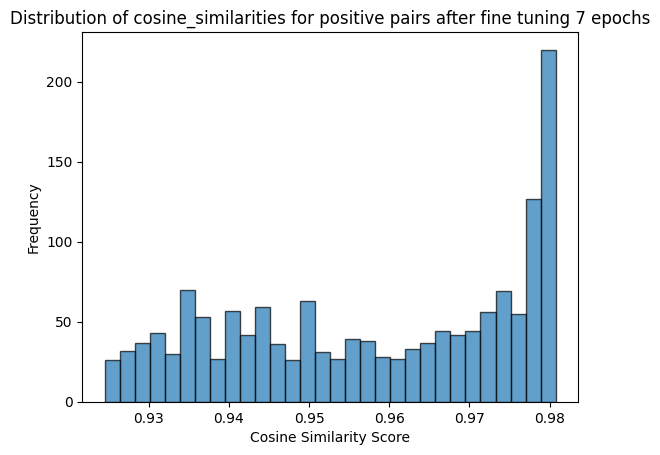

id ticker                 Start Date  \
0        0   APPL 2024-08-14 23:13:20.863736   
2        2   APPL 2024-08-12 23:13:20.863736   
3        3   APPL 2024-08-11 23:13:20.863736   
5        5   APPL 2024-08-09 23:13:20.863736   
6        6   APPL 2024-08-08 23:13:20.863736   
...    ...    ...                        ...   
2991  2991   MSFN 2023-04-11 23:13:20.863736   
2994  2994   MSFN 2023-04-08 23:13:20.863736   
2995  2995   MSFN 2023-04-07 23:13:20.863736   
2996  2996   MSFN 2023-04-06 23:13:20.863736   
2999  2999   MSFN 2023-04-03 23:13:20.863736   

                                     text                     time_series  \
0     decline decrease drop negative loss  [[51], [50], [49], [48], [47]]   
2     negative decrease drop loss decline  [[78], [77], [76], [75], [74]]   
3      growth positive gain rise increase  [[67], [68], [69], [70], [71]]   
5     drop decrease decline negative loss  [[57], [56], [55], [54], [53]]   
6      positive gain growth increase rise  [[75], [76], [77], [78], [79]]   
...                                   ...                             ...   
2991   gain growth rise increase positive  [[82], [83], [84], [85], [86]]   
2994  decline decrease negative loss drop  [[97], [96], [95], [94], [93]]   
2995   rise positive increase growth gain  [[88], [89], [90], [91], [92]]   
2996   positive gain growth increase rise  [[91], [92], [93], [94], [95]]   
2999  negative decrease decline loss drop  [[57], [56], [55], [54], [53]]   

      label  cosine_similarity  
0         1           0.969699  
2         1           0.959337  
3         1           0.967799  
5         1           0.979208  
6         1           0.955159  
...     ...                ...  
2991      1           0.945139  
2994      1           0.934047  
2995      1           0.937572  
2996      1           0.934083  
2999      1           0.979208  

[1518 rows x 7 columns]

In [ ]:
after_one_epoch_all_preds_df_positives['cosine_similarity'].plot(kind='hist', bins=30, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of cosine_similarities for positive pairs after fine tuning 8 epochs')

# Show the plot
plt.show()
after_one_epoch_all_preds_df_positives

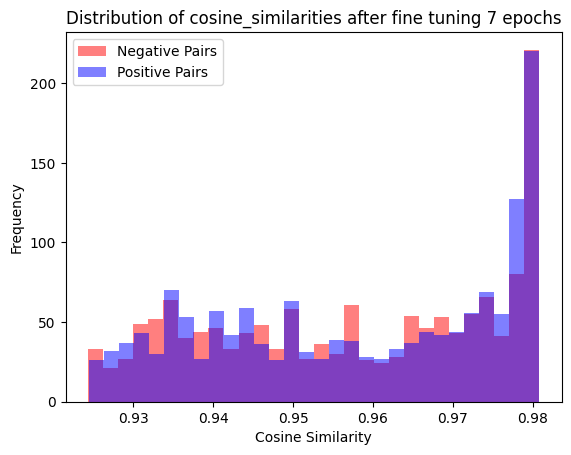

In [ ]:
df[df['label'] == -1]['cosine_similarity'].plot(kind='hist', bins=30, alpha=0.5, color='red', label='Negative Pairs')

# Histogram for category 1
df[df['label'] == 1]['cosine_similarity'].plot(kind='hist', bins=30, alpha=0.5, color='blue', label='Positive Pairs')

# Adding labels and legend
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of cosine_similarities after fine tuning 8 epochs')
plt.legend()

# Show the plot
plt.show()

In [3]:
import data_helper_v2 as dh
import model_helper as mh
model = mh.get_model(ts_encoder_config={"name": 'TSTransformerBaseEncoder'}, text_encoder_config={"name": 'bert-base-uncased', "auto-pre-trained": True}, projection_dim=500, ts_window=5)
stock_emotions_df = dh.get_data("stock_emotions", model=model)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [4]:
stock_emotions_df

id ticker                                               text  \
0     100028   AAPL  Apple it’s just too funny and easy to laugh at...   
1     100205   AAPL  Apple I guess it’s time to readjust my screen ...   
2     100240   AAPL  Apple bulls believing every day green  [grinni...   
3     100315   AAPL  Apple These going to PAY BIGLY tomorrow  [grim...   
4     100441   AAPL  Apple Bulls believing the Corona virus  [micro...   
...      ...    ...                                                ...   
1869  106259    XOM  Exxon Mobil sold it at 34.8 , I’m feeling smar...   
1870  106417    XOM  Exxon Mobil I  [eyes]  a crossover forming on ...   
1871  106651    XOM  Exxon Mobil dividend cut is coming ?  [confoun...   
1872  106734    XOM  Exxon Mobil must be one of the ugliest charts ...   
1873  107026    XOM  Exxon Mobil seeking alpha garbage blowing up m...   

     start_date                                        time_series  \
0    2020-01-06  [[74.94999694824219], [74.59750366210938], [75...   
1    2020-01-16  [[78.80999755859375], [79.68250274658203], [79...   
2    2020-01-21  [[79.14250183105469], [79.42500305175781], [79...   
3    2020-01-27  [[77.23750305175781], [79.42250061035156], [81...   
4    2020-01-31  [[77.37750244140625], [77.16500091552734], [79...   
...         ...                                                ...   
1869 2020-09-30  [[76.0], [77.87000274658203], [75.870002746582...   
1870 2020-10-08  [[116.88999938964844], [117.08000183105467], [...   
1871 2020-10-22  [[165.6999969482422], [166.72000122070312], [1...   
1872 2020-10-29  [[98.35749816894533], [97.0], [97.272499084472...   
1873 2020-11-17  [[34.99051284790039], [35.29411697387695], [34...   

                                              all_dates  label  \
0     3   2020-01-06
4   2020-01-07
5   2020-01-08
6...      1   
1     11   2020-01-16
12   2020-01-17
13   2020-01-2...      1   
2     13   2020-01-21
14   2020-01-22
15   2020-01-2...      1   
3     17   2020-01-27
18   2020-01-28
19   2020-01-2...      1   
4     21   2020-01-31
22   2020-02-03
23   2020-02-0...      1   
...                                                 ...    ...   
1869  189   2020-09-30
190   2020-10-01
191   2020-1...      0   
1870  195   2020-10-08
196   2020-10-09
197   2020-1...      0   
1871  205   2020-10-22
206   2020-10-23
207   2020-1...      0   
1872  210   2020-10-29
211   2020-10-30
212   2020-1...      0   
1873  223   2020-11-17
224   2020-11-18
225   2020-1...      0   

                                     past_time_features  
0             [[1, 6], [1, 7], [1, 8], [1, 9], [1, 10]]  
1         [[1, 16], [1, 17], [1, 21], [1, 22], [1, 23]]  
2         [[1, 21], [1, 22], [1, 23], [1, 24], [1, 27]]  
3         [[1, 27], [1, 28], [1, 29], [1, 30], [1, 31]]  
4             [[1, 31], [2, 3], [2, 4], [2, 5], [2, 6]]  
...                                                 ...  
1869      [[9, 30], [10, 1], [10, 2], [10, 5], [10, 6]]  
1870   [[10, 8], [10, 9], [10, 12], [10, 13], [10, 14]]  
1871  [[10, 22], [10, 23], [10, 26], [10, 27], [10, ...  
1872    [[10, 29], [10, 30], [11, 2], [11, 3], [11, 4]]  
1873  [[11, 17], [11, 18], [11, 19], [11, 20], [11, ...  

[1874 rows x 8 columns]

In [9]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel

# Step 1: Load the configuration and model
config = TimeSeriesTransformerConfig(prediction_length=12, lags_sequence=[1, 2, 3])
model = TimeSeriesTransformerModel(config)

def ids_tensor(shape, vocab_size):
    return torch.randint(low=0, high=vocab_size, size=shape)

# Step 2: Pass your input time series data to the model
# Assuming input_data is your tensor with shape [batch_size, sequence_length, num_features]
# input_data should be a PyTorch tensor
import torch

# Example dimensions
batch_size = 32
sequence_length = 50
num_features = 4

inputs = dict()
context_length = 5
batch_size = 2
cardinality = 5
num_time_features = 10
content_length = 8
prediction_length = 2
lags_sequence = [2, 3]
past_length = context_length + max(lags_sequence)

# encoder inputs
#inputs["static_categorical_features"] = ids_tensor([batch_size, 1], cardinality)
inputs["static_real_features"] = torch.randn([batch_size, 1])
inputs["past_time_features"] = torch.randn([batch_size, past_length, num_time_features])
inputs["past_values"] = torch.randn([batch_size, past_length])
inputs["past_observed_mask"] = torch.ones([batch_size, past_length])

# decoder inputs
inputs["future_time_features"] = torch.randn([batch_size, prediction_length, num_time_features])
inputs["future_values"] = torch.randn([batch_size, prediction_length])

outputs = model(**inputs)

# Step 4: Extract the embeddings
embeddings = outputs.last_hidden_state  # Shape: [batch_size, sequence_length, hidden_size]

# embeddings now contains the output from the last hidden layer, which you can use as desired.


ValueError: lags cannot go further than history length, found lag 12 while history length is only 10

In [43]:
from huggingface_hub import hf_hub_download
import torch
from transformers import TimeSeriesTransformerModel

file = hf_hub_download(
    repo_id="hf-internal-testing/tourism-monthly-batch", filename="train-batch.pt", repo_type="dataset"
)
batch = torch.load(file)

model = TimeSeriesTransformerModel.from_pretrained("huggingface/time-series-transformer-tourism-monthly")

# during training, one provides both past and future values
# as well as possible additional features
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"],
    static_real_features=batch["static_real_features"],
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
)

last_hidden_state = outputs.last_hidden_state
model.config

TimeSeriesTransformerConfig {
  "_name_or_path": "huggingface/time-series-transformer-tourism-monthly",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "architectures": [
    "TimeSeriesTransformerForPrediction"
  ],
  "attention_dropout": 0.1,
  "cardinality": [
    366
  ],
  "context_length": 24,
  "d_model": 26,
  "decoder_attention_heads": 2,
  "decoder_ffn_dim": 32,
  "decoder_layerdrop": 0.1,
  "decoder_layers": 2,
  "distribution_output": "student_t",
  "dropout": 0.1,
  "embedding_dimension": [
    6
  ],
  "encoder_attention_heads": 2,
  "encoder_ffn_dim": 32,
  "encoder_layerdrop": 0.1,
  "encoder_layers": 2,
  "feature_size": 27,
  "init_std": 0.02,
  "input_size": 1,
  "is_encoder_decoder": true,
  "lags_sequence": [
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    11,
    12,
    13,
    23,
    24,
    25,
    35,
    36,
    37
  ],
  "loss": "nll",
  "model_type": "time_series_transformer",
  "num_dynamic_real_features": 0,
  "num_parallel_samples":

In [72]:
from huggingface_hub import hf_hub_download
import torch
from transformers import TimeSeriesTransformerModel

file = hf_hub_download(
    repo_id="hf-internal-testing/tourism-monthly-batch", filename="train-batch.pt", repo_type="dataset"
)
batch = torch.load(file)

model = TimeSeriesTransformerModel.from_pretrained("ibm-granite/granite-timeseries-ttm-v1")

#print(model.config)
#config.lags_sequence = [
#    1,
#    2,
#    3,
#    4,
#    5,
#    6,
#    7,
#    11,
#    12,
#    13,
#    23,
#    24,
#    25,
#    35,
#    36,
#    37
#  ]
## during training, one provides both past and future values
# as well as possible additional features
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    #static_categorical_features=batch["static_categorical_features"],
    static_real_features=batch["static_real_features"],
    #future_values=batch["future_values"],
    #future_time_features=batch["future_time_features"],
)

last_hidden_state = outputs.last_hidden_state

You are using a model of type tinytimemixer to instantiate a model of type time_series_transformer. This is not supported for all configurations of models and can yield errors.
Some weights of TimeSeriesTransformerModel were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-v1 and are newly initialized: ['decoder.embed_positions.weight', 'decoder.layernorm_embedding.bias', 'decoder.layernorm_embedding.weight', 'decoder.layers.0.encoder_attn.k_proj.bias', 'decoder.layers.0.encoder_attn.k_proj.weight', 'decoder.layers.0.encoder_attn.out_proj.bias', 'decoder.layers.0.encoder_attn.out_proj.weight', 'decoder.layers.0.encoder_attn.q_proj.bias', 'decoder.layers.0.encoder_attn.q_proj.weight', 'decoder.layers.0.encoder_attn.v_proj.bias', 'decoder.layers.0.encoder_attn.v_proj.weight', 'decoder.layers.0.encoder_attn_layer_norm.bias', 'decoder.layers.0.encoder_attn_layer_norm.weight', 'decoder.layers.0.fc1.bias', 'decoder.layers.0.fc1.weight', 'decoder.layers.0.fc2.bi

ValueError: lags cannot go further than history length, found lag 7 while history length is only 61

In [73]:
for key in batch.keys():

    print(key)
    print(batch[key].shape)

static_categorical_features
torch.Size([64, 1])
static_real_features
torch.Size([64, 1])
past_time_features
torch.Size([64, 61, 2])
past_values
torch.Size([64, 61])
past_observed_mask
torch.Size([64, 61])
future_time_features
torch.Size([64, 24, 2])
future_values
torch.Size([64, 24])
future_observed_mask
torch.Size([64, 24])


In [77]:
batch['past_time_features']

tensor([[[ 0.1364,  2.2175],
         [ 0.2273,  2.2201],
         [ 0.3182,  2.2227],
         ...,
         [-0.0455,  2.3483],
         [ 0.0455,  2.3502],
         [ 0.1364,  2.3522]],

        [[ 0.1364,  2.1847],
         [ 0.2273,  2.1875],
         [ 0.3182,  2.1903],
         ...,
         [-0.0455,  2.3243],
         [ 0.0455,  2.3263],
         [ 0.1364,  2.3284]],

        [[ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         ...,
         [-0.2273,  0.6990],
         [-0.1364,  0.7782],
         [-0.0455,  0.8451]],

        ...,

        [[ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         ...,
         [ 0.4091,  1.5563],
         [ 0.5000,  1.5682],
         [-0.5000,  1.5798]],

        [[-0.4091,  1.7993],
         [-0.3182,  1.8062],
         [-0.2273,  1.8129],
         ...,
         [ 0.5000,  2.0828],
         [-0.5000,  2.0864],
         [-0.4091,  2.0899]],

        [[ 0.5000,  1.1139],
       

In [26]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel

# Initializing a default Time Series Transformer configuration
configuration = TimeSeriesTransformerConfig(prediction_length=10)

# Randomly initializing a model from the configuration
model = TimeSeriesTransformerModel(configuration)

# Accessing the model configuration
configuration = model.config

In [28]:
from transformers import AutoformerConfig, AutoformerModel

# Initializing a default Autoformer configuration
configuration = AutoformerConfig(prediction_length=10)

# Randomly initializing a model (with random weights) from the configuration
model = AutoformerModel(configuration)

# Accessing the model configuration
configuration = model.config

ValueError: The `prediction_length` config needs to be specified.

In [38]:
# Load Model from HF Model Hub mentioning the branch name in revision field

model = TinyTimeMixerForPrediction.from_pretrained(
                "https://huggingface.co/ibm/TTM", revision="main"
            ) 

# Do zeroshot
zeroshot_trainer = Trainer(
        model=model,
        args=zeroshot_forecast_args,
        )
    

zeroshot_output = zeroshot_trainer.evaluate(dset_test)


# Freeze backbone and enable few-shot or finetuning:

# freeze backbone
for param in model.backbone.parameters():
  param.requires_grad = False

finetune_forecast_trainer = Trainer(
        model=model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
finetune_forecast_trainer.train()
fewshot_output = finetune_forecast_trainer.evaluate(dset_test)


IndentationError: unexpected indent (744923598.py, line 12)

In [10]:
from datasets import load_dataset

dataset = load_dataset("monash_tsf", "tourism_monthly")


c:\Users\eoinp\anaconda3\envs\deepl\Lib\site-packages\datasets\load.py:1486: FutureWarning: The repository for monash_tsf contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/monash_tsf
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Generating validation split: 100%|██████████| 366/366 [00:00<00:00, 1270.80 examples/s]


In [27]:
dataset
train_example = dataset['train'][0]
print(train_example.keys())
print(train_example['start'])
print(train_example['target'])
print(train_example['feat_static_cat'])
print(train_example['feat_dynamic_real'])
print(train_example['item_id'])



dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])
1979-01-01 00:00:00
[1149.8699951171875, 1053.8001708984375, 1388.8797607421875, 1783.3702392578125, 1921.025146484375, 2704.94482421875, 4184.41357421875, 4148.35400390625, 2620.72509765625, 1650.300048828125, 1115.9200439453125, 1370.6251220703125, 1096.31494140625, 978.4600219726562, 1294.68505859375, 1480.465087890625, 1748.865234375, 2216.920166015625, 4690.5185546875, 4682.8642578125, 2459.579833984375, 1484.4901123046875, 1028.985107421875, 1109.3648681640625, 960.8751220703125, 896.35009765625, 1118.6551513671875, 1619.9949951171875, 1847.994873046875, 2367.044921875, 4991.16015625, 4772.9443359375, 2894.678466796875, 1860.4801025390625, 1185.150146484375, 1313.659912109375, 1160.9150390625, 1061.5048828125, 1301.77001953125, 1794.3797607421875, 2106.455078125, 2789.034912109375, 4917.8466796875, 4994.4833984375, 3016.754150390625, 1941.505126953125, 1234.135009765625, 1378.72021484375, 1182.97497

In [41]:


# Load the IBM Granite model
model = TimeSeriesTransformerModel.from_pretrained("ibm-granite/granite-timeseries-ttm-v1")

import torch

# Assuming you have the time series data
batch_size = 10
sequence_length = 50
feature_dim = 20

# Example time series data with shape (batch_size, sequence_length, feature_dim)
time_series_data = torch.rand((batch_size, sequence_length, feature_dim)).float()

# Generating past_time_features, could be similar to time_series_data or additional features
num_additional_features = 5  # Number of additional time-related features
past_time_features = torch.rand((batch_size, sequence_length, num_additional_features)).float()

# Generating past_observed_mask, a binary mask indicating observed time steps
# Assuming all time steps are observed in this example
past_observed_mask = torch.ones((batch_size, sequence_length)).float()

# Now you can pass these to the model
outputs = model(time_series_data, past_time_features, past_observed_mask)

# Get the last hidden state
last_hidden_state = outputs.last_hidden_state


You are using a model of type tinytimemixer to instantiate a model of type time_series_transformer. This is not supported for all configurations of models and can yield errors.
Some weights of TimeSeriesTransformerModel were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-v1 and are newly initialized: ['decoder.embed_positions.weight', 'decoder.layernorm_embedding.bias', 'decoder.layernorm_embedding.weight', 'decoder.layers.0.encoder_attn.k_proj.bias', 'decoder.layers.0.encoder_attn.k_proj.weight', 'decoder.layers.0.encoder_attn.out_proj.bias', 'decoder.layers.0.encoder_attn.out_proj.weight', 'decoder.layers.0.encoder_attn.q_proj.bias', 'decoder.layers.0.encoder_attn.q_proj.weight', 'decoder.layers.0.encoder_attn.v_proj.bias', 'decoder.layers.0.encoder_attn.v_proj.weight', 'decoder.layers.0.encoder_attn_layer_norm.bias', 'decoder.layers.0.encoder_attn_layer_norm.weight', 'decoder.layers.0.fc1.bias', 'decoder.layers.0.fc1.weight', 'decoder.layers.0.fc2.bi

RuntimeError: The size of tensor a (20) must match the size of tensor b (50) at non-singleton dimension 2

In [51]:
df

Date        Open        High         Low       Close   Adj Close  \
0    2019-12-31   72.482498   73.419998   72.379997   73.412498   71.520821   
1    2020-01-02   74.059998   75.150002   73.797501   75.087502   73.152649   
2    2020-01-03   74.287498   75.144997   74.125000   74.357498   72.441460   
3    2020-01-06   73.447502   74.989998   73.187500   74.949997   73.018677   
4    2020-01-07   74.959999   75.224998   74.370003   74.597504   72.675278   
..          ...         ...         ...         ...         ...         ...   
249  2020-12-24  131.320007  133.460007  131.100006  131.970001  129.679718   
250  2020-12-28  133.990005  137.339996  133.509995  136.690002  134.317825   
251  2020-12-29  138.050003  138.789993  134.339996  134.869995  132.529404   
252  2020-12-30  135.580002  135.990005  133.399994  133.720001  131.399368   
253  2020-12-31  134.080002  134.740005  131.720001  132.690002  130.387222   

        Volume  
0    100805600  
1    135480400  
2    146322800  
3    118387200  
4    108872000  
..         ...  
249   54930100  
250  124486200  
251  121047300  
252   96452100  
253   99116600  

[254 rows x 7 columns]

In [52]:
import pandas as pd
import torch

# Load the CSV file
file_path = './data/stock_emotions/price/AAPL.csv'
df = pd.read_csv(file_path)

# Select a single row to predict from (assuming row 10)
row_idx = 10

# Define past and future horizons
past_horizon = 5
future_horizon = 3

# Extract past values
past_values = df['Close'].iloc[row_idx-past_horizon:row_idx].values
past_values = torch.tensor(past_values, dtype=torch.float32)

# Extract past time features (e.g., day of the week)
past_time_features = pd.to_datetime(df['Date'].iloc[row_idx-past_horizon:row_idx])
past_time_features = torch.tensor(past_time_features.dt.dayofweek.values, dtype=torch.float32)

# Generate a binary observed mask (assume all values are observed in this example)
past_observed_mask = torch.ones(past_horizon, dtype=torch.float32)

# Assuming no static features for this example
static_real_features = torch.tensor([], dtype=torch.float32)

# Extract future values (target values)
future_values = df['Close'].iloc[row_idx:row_idx+future_horizon].values
future_values = torch.tensor(future_values, dtype=torch.float32)

# Extract future time features
future_time_features = pd.to_datetime(df['Date'].iloc[row_idx:row_idx+future_horizon])
future_time_features = torch.tensor(future_time_features.dt.dayofweek.values, dtype=torch.float32)

# Print out the variables
print("past_values:", past_values)
print("past_time_features:", past_time_features)
print("past_observed_mask:", past_observed_mask)
print("static_real_features:", static_real_features)
print("future_values:", future_values)
print("future_time_features:", future_time_features)



past_values: tensor([75.7975, 77.4075, 77.5825, 79.2400, 78.1700])
past_time_features: tensor([2., 3., 4., 0., 1.])
past_observed_mask: tensor([1., 1., 1., 1., 1.])
static_real_features: tensor([])
future_values: tensor([77.8350, 78.8100, 79.6825])
future_time_features: tensor([2., 3., 4.])


In [63]:
from transformers import TimeSeriesTransformerModel

# Load the pre-trained model
model = TimeSeriesTransformerModel.from_pretrained('ibm-granite/granite-timeseries-ttm-v1')

# Set the model to evaluation mode
model.eval()

# Example data from earlier steps
past_values = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0]).unsqueeze(0)  # Shape: [batch_size, past_horizon]
past_time_features = torch.tensor([0, 1, 2, 3, 4]).unsqueeze(0)     # Shape: [batch_size, past_horizon, num_features]
past_observed_mask = torch.tensor([1, 1, 1, 1, 1]).unsqueeze(0)     # Shape: [batch_size, past_horizon]
static_real_features =  torch.empty((batch_size, 1, 0)).float().unsqueeze(0)                # Shape: [batch_size, num_static_features]
future_values = torch.tensor([6.0, 7.0, 8.0]).unsqueeze(0)          # Shape: [batch_size, future_horizon]
future_time_features = torch.tensor([5, 6, 0]).unsqueeze(0)         # Shape: [batch_size, future_horizon, num_features]


You are using a model of type tinytimemixer to instantiate a model of type time_series_transformer. This is not supported for all configurations of models and can yield errors.
Some weights of TimeSeriesTransformerModel were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-v1 and are newly initialized: ['decoder.embed_positions.weight', 'decoder.layernorm_embedding.bias', 'decoder.layernorm_embedding.weight', 'decoder.layers.0.encoder_attn.k_proj.bias', 'decoder.layers.0.encoder_attn.k_proj.weight', 'decoder.layers.0.encoder_attn.out_proj.bias', 'decoder.layers.0.encoder_attn.out_proj.weight', 'decoder.layers.0.encoder_attn.q_proj.bias', 'decoder.layers.0.encoder_attn.q_proj.weight', 'decoder.layers.0.encoder_attn.v_proj.bias', 'decoder.layers.0.encoder_attn.v_proj.weight', 'decoder.layers.0.encoder_attn_layer_norm.bias', 'decoder.layers.0.encoder_attn_layer_norm.weight', 'decoder.layers.0.fc1.bias', 'decoder.layers.0.fc1.weight', 'decoder.layers.0.fc2.bi

In [65]:
# Pass the inputs through the model
outputs = model(
    past_values=past_values,
    past_time_features=past_time_features,
    past_observed_mask=past_observed_mask,
    static_real_features=static_real_features,
    future_values=future_values,
    future_time_features=future_time_features,
)

# Extract the last hidden state from the model's output
last_hidden_state = outputs.last_hidden_state

# Print the last hidden state
print("Last Hidden State:", last_hidden_state)


RuntimeError: Tensors must have same number of dimensions: got 4 and 2

In [68]:
import torch
from transformers import TimeSeriesTransformerModel

# Load the pre-trained model
model = TimeSeriesTransformerModel.from_pretrained('ibm-granite/granite-timeseries-ttm-v1')
model.eval()

# Example data from earlier steps (modify as needed for your data)
batch_size = 1
past_values = torch.tensor([[1.0, 2.0, 3.0, 4.0, 5.0]])  # Shape: [batch_size, past_horizon]
past_time_features = torch.tensor([[0, 1, 2, 3, 4]])     # Shape: [batch_size, past_horizon, num_features]
past_observed_mask = torch.tensor([[1, 1, 1, 1, 1]])     # Shape: [batch_size, past_horizon]

# If no static features, create an empty tensor with the correct shape
static_real_features = torch.empty((batch_size, 0)).float()  # Shape: [batch_size, 1, 0]

future_values = torch.tensor([[6.0, 7.0, 8.0]])  # Shape: [batch_size, future_horizon]
future_time_features = torch.tensor([[5, 6, 0]])  # Shape: [batch_size, future_horizon, num_features]

# Pass the inputs through the model
outputs = model(
    past_values=past_values,
    past_time_features=past_time_features,
    past_observed_mask=past_observed_mask,
    static_real_features=static_real_features,  # Pass an empty tensor here
    future_values=future_values,
    future_time_features=future_time_features,
)

# Extract the last hidden state from the model's output
last_hidden_state = outputs.last_hidden_state

# Print the last hidden state
print("Last Hidden State:", last_hidden_state)


You are using a model of type tinytimemixer to instantiate a model of type time_series_transformer. This is not supported for all configurations of models and can yield errors.
Some weights of TimeSeriesTransformerModel were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-v1 and are newly initialized: ['decoder.embed_positions.weight', 'decoder.layernorm_embedding.bias', 'decoder.layernorm_embedding.weight', 'decoder.layers.0.encoder_attn.k_proj.bias', 'decoder.layers.0.encoder_attn.k_proj.weight', 'decoder.layers.0.encoder_attn.out_proj.bias', 'decoder.layers.0.encoder_attn.out_proj.weight', 'decoder.layers.0.encoder_attn.q_proj.bias', 'decoder.layers.0.encoder_attn.q_proj.weight', 'decoder.layers.0.encoder_attn.v_proj.bias', 'decoder.layers.0.encoder_attn.v_proj.weight', 'decoder.layers.0.encoder_attn_layer_norm.bias', 'decoder.layers.0.encoder_attn_layer_norm.weight', 'decoder.layers.0.fc1.bias', 'decoder.layers.0.fc1.weight', 'decoder.layers.0.fc2.bi

RuntimeError: Tensors must have same number of dimensions: got 3 and 2

In [6]:
import torch
import torch.nn as nn
from transformers import TimeSeriesTransformerModel, TimeSeriesTransformerConfig
k = 5 #number of inputs
lags_sequence=[1, 2, 3]
context_length=2
#context_lag = 
num_features = 2
config = TimeSeriesTransformerConfig(
    prediction_length=0,  
    context_length=context_length,
    #decoder_attention_heads=1,
    #encoder_attention_heads=1,
    #d_model=74,
    lags_sequence=lags_sequence,
    feature_size=len(lags_sequence) + num_features + 2
)

#Notes:
"""
- Length of k in the below torch tensors need to be size: context_length + max(lags_sequence)
- Not sure what feature_size is actually representing here but I force it to the same size as mat1 dim 2 currently (errors otherwise)
- No idea why last_hidden_state is an empty tensor currently...
- Currently assuming encoder_last_hidden_state is what I want to use as it is the TS embeddings w/o prediction
- mat1 dim 2 effective change seems to be changing lags_sequence (seems to be addition of this) 
- mat 1 dim 2 also effected by past_time_features num_features (third dim) (concatenation of len(lags_sequence), num_features of past_time_features and something else)
- unaccounted for about 2 of mat1 dim 2
"""
model = TimeSeriesTransformerModel(config)

import data_helper_v2 as dh

df = dh.get_data(data_source="stock_emotions", text_window=k)


past_values = torch.tensor([[x[0] for x in df.iloc[0]["time_series"]]])  #torch.rand(32, k)  
past_observed_mask = torch.ones(1, k)
past_time_features = torch.tensor([df.iloc[0]["past_time_features"]])  #torch.rand(32, k, num_features) 

encoder_outputs = model(past_values = past_values, past_observed_mask=past_observed_mask, past_time_features=past_time_features)

last_hidden_state = encoder_outputs.encoder_last_hidden_state

AttributeError: 'NoneType' object has no attribute 'get_text_tokenizer'

In [1]:
import data_helper_v2 as dh
import model_helper as mh

model = mh.get_model(ts_encoder_config={"name": 'TSTransformerBaseEncoder'}, text_encoder_config={"name": 'bert-base-uncased', "auto-pre-trained": True})

df = dh.get_data(data_source="stock_emotions")

c:\Users\eoinp\anaconda3\envs\deepl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
past_time_features = []

for idx, row in df.iterrows():
    past_time_features_this_row = []

    for i in row["all_dates"]:
        past_time_features_this_row.append([i.month, i.day])
    past_time_features.append(past_time_features_this_row)

df["past_time_features"] = past_time_features

In [3]:
df.iloc[0]["time_series"]

[[74.94999694824219],
 [74.59750366210938],
 [75.79750061035156],
 [77.40750122070312],
 [77.5824966430664]]

In [1]:
import data_helper_v2 as dh
import model_helper as mh

k = 5
model = mh.get_model(ts_encoder_config={"name": 'TSTransformerBaseEncoder'}, text_encoder_config={"name": 'bert-base-uncased', "auto-pre-trained": True}, ts_window=k, projection_dim=64)

train_dl, val_dl, test_dl = dh.get_data(data_source="stock_emotions", text_window=k, model=model)

c:\Users\eoinp\anaconda3\envs\deepl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please

In [12]:
preds = mh.cosine_similarity_custom(output[0].detach().numpy(), output[1].detach().numpy())

all_preds = (preds >= 0.5).astype(int).tolist()

In [1]:
import json
import matplotlib.pyplot as plt

file_path = 'output.json'  # Make sure to use the correct path

with open(file_path, 'r') as f:
    data = json.load(f)


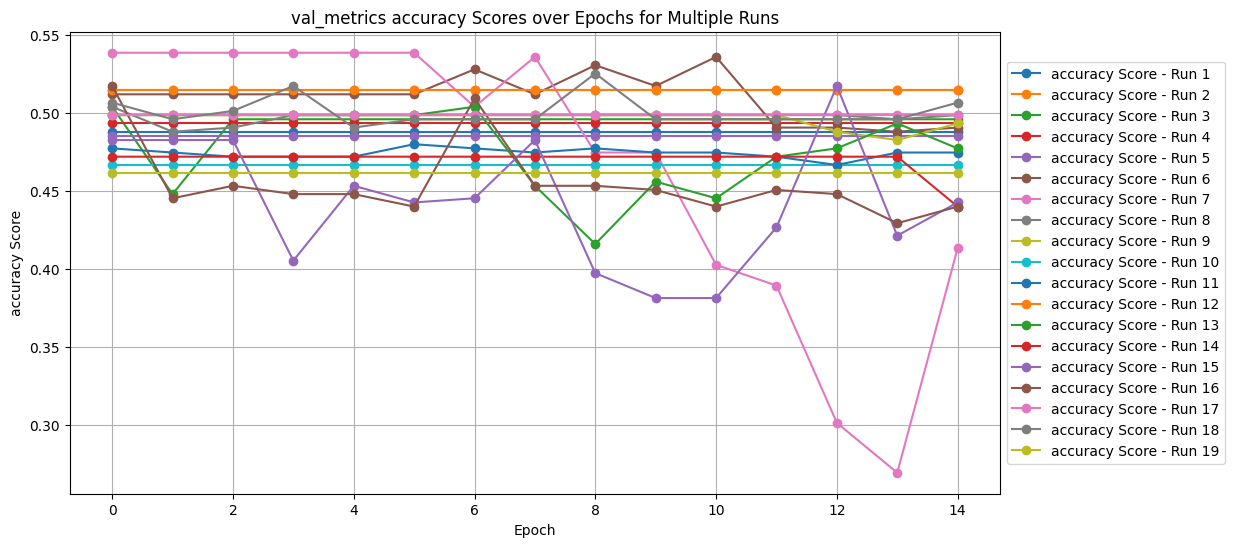

In [16]:
f1_scores = []
epochs = []

plot_value ='accuracy'
metrics_pool = 'val_metrics'
for entry in data:
    epochs.append(entry['epoch'])
    f1_scores.append(entry[metrics_pool][plot_value])

# Step 3: Plot all F1 scores on the same graph
plt.figure(figsize=(12, 6))

# Plot each set of F1 scores
for i, f1 in enumerate(f1_scores):
    plt.plot(epochs[i], f1, marker='o', label=f'{plot_value} Score - Run {i+1}')

plt.title(f'{metrics_pool} {plot_value} Scores over Epochs for Multiple Runs')
plt.xlabel('Epoch')
plt.ylabel(f'{plot_value} Score')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import data_helper_v3 as dh3
data_config = {
    "name": "stock_net",
    "text_path": "./data/stocknet-dataset/tweet/organised_tweet.csv",
    "ts_path": "./data/stocknet-dataset/price/raw/",
    "ts_date_col": 'Date',
    'text_date_col': 'created_at'
}
df = dh3.get_data(data_source=data_config, model=None, text_window=3, loaders=False)

c:\Users\eoinp\anaconda3\envs\deepl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Skipping window for ticker D on 2015-08-14: empty vocabulary; perhaps the documents only contain stop words


In [3]:
import model_helper as mh

model = mh.get_model(ts_encoder_config={"name":"TimeSeriesTransformerModel", "k":5, "context_length": 2, "prediction_length": 0, "lags_sequence":[1, 2, 3], "num_features":3}, 
                     text_encoder_config={"name": 'bert-base-uncased', 'auto-pre-trained': True}, 
                     projection_dim=500, ts_window=5)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [4]:
import data_helper_v3 as dh3
dataset = dh3.CustomDataset(df=df, text_tokenizer=model.get_text_tokenizer())

In [5]:
from torch.utils.data import Dataset, DataLoader, random_split
#import data_helper_v3 as dh3
dataset = dh3.CustomDataset(df=df, text_tokenizer=model.get_text_tokenizer())
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=6)#, collate_fn=dh3.collate_fn)

In [38]:
import json
import difflib

def compare_dicts_as_strings(dict1, dict2):
    for key in dict1.keys():
        if key != 'text_selection_method' and key != 'negatives_creation':
            #These have particular serialise/deseerialise issues where it's originally a tuple and saved as a list 
            if dict1[key] != dict2[key]:
                return False
        else:
            if dict1[key][0] != dict2[key][0] or dict1[key][1] != dict2[key][1]:
                return False
    return True


    
def check_args_not_used(data_parameters, model_parameters, output_file):
    with open(output_file, 'r') as file:
        data = json.load(file)
    for i in data:
        seen_dataset_params = i['dataset_params']
        seen_model_params = i['model_params']
        if compare_dicts_as_strings(seen_dataset_params, data_parameters) or compare_dicts_as_strings(seen_model_params, model_parameters):
            return False
    return True
data_parameters = {'ts_window': 6, 'ts_overlap': 'start', 'text_window': 1, 'text_selection_method': ('TFIDF', 5), 'data_source': {'name': 'stock_emotion', 'text_path': './data/stock_emotions/tweet/processed_stockemo.csv', 'ts_path': './data/stock_emotions/price/', 'ts_date_col': 'Date', 'text_date_col': 'date', 'text_col': 'text'}, 'negatives_creation': ('naive', 60), 'random_state': 42}
model_parameters = {'ts_encoder': {'name': 'TimeSeriesTransformerModel', 'ts_window': 6, 'context_length': 1, 'prediction_length': 0, 'lags_sequence': [1, 2, 3, 4, 5], 'num_features': 3}, 'text_encoder': {'name': 'bert-base-uncased'}, 'text_encoder_pretrained': True, 'text_aggregation_method': 'mean', 'projection_dim': 500, 'learning_rate': 1e-06, 'optimizer': 'adam', 'criterion': 'CosineEmbeddingLoss', 'num_epochs': 10, 'batch_size': 6, 'num_workers': 6}
check_args_not_used(data_parameters, model_parameters, './output_sofiane_plotting.json')


False

# Testing Below

In [1]:
import ijson
import pandas as pd

def process_large_json_to_dataframes(json_file):
    # Lists to hold data for time series and text DataFrames
    ts_data = []
    text_data = []

    # Open the file and use ijson to parse it incrementally
    with open(json_file, 'r') as file:
        # Stream the array of objects in the JSON file
        objects = ijson.items(file, 'item')
        
        for row in objects:
            # Extract text data: ticker, pub_time (date), title and text
            if 'labels' in row and row['labels']:
                ticker = row['labels']['ticker']
                pub_time = row['pub_time']
                title = row['title']
                text = row['text']

                # Append text-related data
                text_data.append({
                    'ticker': ticker,
                    'date': pub_time,
                    'title': title,
                    'text': text
                })

                # Extract time series data for the ticker
                for day in ['1day', '2day', '3day']:
                    end_price = row['labels'].get(f'end_price_{day}')
                    end_time = row['labels'].get(f'end_time_{day}')

                    if end_price and end_time:
                        ts_data.append({
                            'ticker': ticker,
                            'Date': end_time,
                            'Close': end_price
                        })

    # Create DataFrames
    ts_df = pd.DataFrame(ts_data)
    text_df = pd.DataFrame(text_data)

    return ts_df, text_df

# Example usage
ts_df, text_df = process_large_json_to_dataframes('evaluate_news.json')

# Show resulting dataframes
print(ts_df.head())
print(text_df.head())


  ticker                       Date    Close
0    MIK  2020-12-08 19:11:00-05:00     12.8
1    MIK  2020-12-09 18:45:00-05:00  12.4899
2    MIK  2020-12-10 19:35:00-05:00       13
3    DUK  2020-10-01 16:02:00-04:00    90.05
4    DUK  2020-10-02 19:58:00-04:00       91
  ticker                       date  \
0    MIK  2020-12-08 09:00:00-05:00   
1    DUK  2020-10-01 12:11:00-04:00   
2   PLRX  2020-10-05 08:00:00-04:00   
3         2021-01-18 02:30:00-05:00   
4   DISH  2021-02-22 06:05:00-05:00   

                                               title  \
0  European Wax Center Welcomes Jennifer Vanderve...   
1  Duke Energy to host virtual Environmental, Soc...   
2  Pliant Therapeutics Appoints Mike Ouimette as ...   
3  Radiofrequency Ablation Devices Market Revenue...   
4  DISH Network reports fourth quarter, year-end ...   

                                                text  
0  PLANO, Texas, Dec. 8, 2020 /PRNewswire/ --Euro...  
1  CHARLOTTE, N.C., Oct. 1, 2020 /PRNewswire/ --

In [8]:

ts_df['Date'] = pd.to_datetime(ts_df['Date'])

# Convert 'Close' column to float format
ts_df['Close'] = pd.to_numeric(ts_df['Close'], errors='coerce')  # Coerce handles invalid values by converting them to NaN
ts_df.dtypes

C:\Users\eoinp\AppData\Local\Temp\ipykernel_58828\2843153441.py:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  ts_df['Date'] = pd.to_datetime(ts_df['Date'])


ticker     object
Date       object
Close     float64
dtype: object

In [ ]:
ts_df

In [3]:
text_df

ticker                       date  \
0         MIK  2020-12-08 09:00:00-05:00   
1         DUK  2020-10-01 12:11:00-04:00   
2        PLRX  2020-10-05 08:00:00-04:00   
3              2021-01-18 02:30:00-05:00   
4        DISH  2021-02-22 06:05:00-05:00   
...       ...                        ...   
290894  GRUSF  2021-03-02 07:50:00-05:00   
290895    STT  2021-01-13 06:00:00-05:00   
290896         2020-12-14 08:08:00-05:00   
290897         2020-11-20 12:51:00-05:00   
290898    MMM  2021-01-26 10:45:00-05:00   

                                                    title  \
0       European Wax Center Welcomes Jennifer Vanderve...   
1       Duke Energy to host virtual Environmental, Soc...   
2       Pliant Therapeutics Appoints Mike Ouimette as ...   
3       Radiofrequency Ablation Devices Market Revenue...   
4       DISH Network reports fourth quarter, year-end ...   
...                                                   ...   
290894  Grown Rogue Reports Positive Adjusted EBITDA o...   
290895  Metropolitan Commercial Bank Appoints Ram Pupp...   
290896  Welldoc Submits 510(k) for Bolus and Premixed ...   
290897  $1.6 Billion Worldwide Variable Rate Technolog...   
290898  Outlook on the Non-woven Tape Global Market to...   

                                                     text  
0       PLANO, Texas, Dec. 8, 2020 /PRNewswire/ --Euro...  
1       CHARLOTTE, N.C., Oct. 1, 2020 /PRNewswire/ --D...  
2       SOUTH SAN FRANCISCO, Calif., Oct. 5, 2020 /PRN...  
3       NEW YORK, Jan. 18, 2021 /PRNewswire/ -- With a...  
4       ENGLEWOOD, Colo., Feb. 22, 2021 /PRNewswire/ -...  
...                                                   ...  
290894  MEDFORD, Ore.--(BUSINESS WIRE)--Grown Rogue In...  
290895  NEW YORK--(BUSINESS WIRE)--Metropolitan Commer...  
290896  COLUMBIA, Md.--(BUSINESS WIRE)--Welldoc, a tra...  
290897  DUBLIN--(BUSINESS WIRE)--The "Variable Rate Te...  
290898  DUBLIN--(BUSINESS WIRE)--The "Non-woven Tape M...  

[290899 rows x 4 columns]

In [ ]:
#TODO filter EDT
#filter EDT as there is too much data
#get only unique prices
edt_filtered_df = ts_df.drop_duplicates(subset=['Date', 'ticker'])
#get only those with non-broken time series for a reasonable period (a 3 day time series isn't enough data)

#get those with enough text data to create positive pairs

#get those that are also in stocknet and stock emotion (for industry comparisons)


In [141]:
ts_df = ts_df.drop_duplicates()
ts_df = ts_df.sort_values(by=['ticker', 'Date'])
    
    # Create a new column with the difference in days between consecutive dates (excluding weekends)
ts_df['day_diff'] = ts_df.groupby('ticker')['Date'].diff().dt.days

In [157]:
import pdb
def filter_k_days_consecutive_calendar_days(df, k):
    # Sort by ticker and date
    df = df.sort_values(by=['ticker', 'Date'])
    df['Date'] = df['Date'].apply(lambda x: x.replace(hour=0, minute=0))

    # Create a new column with the difference in calendar days (actual next day, excluding weekends)
    df['day_diff'] = df.groupby('ticker')['Date'].diff().dt.days
    df['day_diff'].fillna(1, inplace=True)  # Replace NaNs in the first row of each ticker group
    
    
    # Consider only differences of 1 or 3 days (allowing for weekends)
    def is_next_calendar_day(x):
        return (x == 1) | (x == 3)  # Allow gaps of 1 or 3 days (weekend)

    # Identify blocks of consecutive calendar days by ticker
    df['block'] = (~is_next_calendar_day(df['day_diff'])).cumsum()
    
    # Filter out blocks where the length is less than k
    result = df.groupby(['ticker', 'block']).filter(lambda x: len(x) >= k)
    
    # Drop the helper columns before returning
    return result#.drop(columns=['day_diff', 'block'])

# Example of using the function with k = 5
k = 7
test_df = filter_k_days_consecutive_calendar_days(ts_df, k)
test_df = test_df.drop_duplicates()



C:\Users\eoinp\AppData\Local\Temp\ipykernel_58828\190128874.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['day_diff'].fillna(1, inplace=True)  # Replace NaNs in the first row of each ticker group


In [158]:
test_df

ticker                      Date     Close  day_diff  block
185518    AAN 2020-05-01 00:00:00+00:00   30.5100       0.0    265
185519    AAN 2020-05-04 00:00:00+00:00   30.9600       3.0    265
153066    AAN 2020-05-07 00:00:00+00:00   33.3500       3.0    265
153067    AAN 2020-05-08 00:00:00+00:00   35.7800       1.0    265
153068    AAN 2020-05-11 00:00:00+00:00   34.5100       3.0    265
...       ...                       ...       ...       ...    ...
271201     ZM 2020-11-12 00:00:00+00:00  420.0000       1.0  94011
271202     ZM 2020-11-13 00:00:00+00:00  429.0000       1.0  94011
744        ZM 2020-11-14 00:00:00+00:00  405.1000       1.0  94011
745        ZM 2020-11-17 00:00:00+00:00  396.2001       3.0  94011
746        ZM 2020-11-18 00:00:00+00:00  401.6800       1.0  94011

[7613 rows x 5 columns]

In [20]:
EDT_tickers = set(text_df['ticker'].unique().tolist())

In [21]:
stockemotion_tickers = set(pd.read_csv("./data/stock_emotions/tweet/processed_stockemo.csv")['ticker'].unique().tolist())

In [22]:
stocknet_tickers = set(pd.read_csv("./data/stocknet/tweet/organised_tweet.csv")['ticker'].unique().tolist())

In [29]:
union_set_2_and_3 = stockemotion_tickers | stocknet_tickers

# Find elements from set1 that are in either set2 or set3
result = EDT_tickers & union_set_2_and_3

In [152]:
ts_df[ts_df['ticker']=='AAXN']

ticker                      Date     Close  day_diff
130614   AAXN 2020-03-17 22:13:00+00:00   57.1500       NaN
130615   AAXN 2020-03-18 22:44:00+00:00   52.7000       1.0
144888   AAXN 2020-03-18 22:44:00+00:00   52.7000       0.0
130616   AAXN 2020-03-19 23:58:00+00:00   60.5000       1.0
144889   AAXN 2020-03-19 23:58:00+00:00   60.5000       0.0
144890   AAXN 2020-03-20 23:55:00+00:00   60.7800       0.0
142776   AAXN 2020-03-26 23:57:00+00:00   77.3300       6.0
142777   AAXN 2020-03-27 20:00:00+00:00   74.4100       0.0
142778   AAXN 2020-03-30 20:00:00+00:00   69.4600       3.0
168504   AAXN 2020-04-02 20:00:00+00:00   62.6400       3.0
168505   AAXN 2020-04-03 20:00:00+00:00   61.5100       1.0
168506   AAXN 2020-04-06 20:31:00+00:00   67.3500       3.0
141741   AAXN 2020-04-09 20:00:00+00:00   74.7000       2.0
141742   AAXN 2020-04-13 20:00:00+00:00   73.4900       4.0
141743   AAXN 2020-04-14 22:02:00+00:00   76.6200       1.0
167754   AAXN 2020-04-24 20:00:00+00:00   71.8400       9.0
167755   AAXN 2020-04-27 21:56:00+00:00   72.1500       3.0
167756   AAXN 2020-04-28 20:00:00+00:00   75.3400       0.0
126765   AAXN 2020-05-07 23:24:00+00:00   75.2500       9.0
126766   AAXN 2020-05-08 23:40:00+00:00   86.2800       1.0
126767   AAXN 2020-05-11 23:06:00+00:00   84.2100       2.0
203547   AAXN 2020-05-13 23:45:00+00:00   80.5800       2.0
203548   AAXN 2020-05-14 23:22:00+00:00   75.8000       0.0
203549   AAXN 2020-05-15 22:45:00+00:00   73.9100       0.0
189498   AAXN 2020-06-03 22:11:00+00:00   91.0000      18.0
189499   AAXN 2020-06-04 21:49:00+00:00   93.3400       0.0
189500   AAXN 2020-06-05 22:48:00+00:00   92.7000       1.0
167448   AAXN 2020-06-15 23:59:00+00:00   97.6700      10.0
167449   AAXN 2020-06-16 22:27:00+00:00   93.8000       0.0
139185   AAXN 2020-06-17 20:58:00+00:00   96.3000       0.0
139186   AAXN 2020-06-18 23:45:00+00:00   92.9000       1.0
139187   AAXN 2020-06-19 20:21:00+00:00   90.1185       0.0
147057   AAXN 2020-07-08 23:31:00+00:00   96.9300      19.0
147058   AAXN 2020-07-09 23:37:00+00:00   96.5000       1.0
147059   AAXN 2020-07-10 20:00:00+00:00   95.9100       0.0
149343   AAXN 2020-07-23 23:20:00+00:00   88.0000      13.0
149344   AAXN 2020-07-24 22:17:00+00:00   85.8600       0.0
149345   AAXN 2020-07-27 20:00:00+00:00   86.4400       2.0
176311   AAXN 2020-07-27 20:00:00+00:00   86.4400       0.0
176312   AAXN 2020-07-28 20:00:00+00:00   85.8500       1.0
135918   AAXN 2020-08-04 23:18:00+00:00   89.0000       7.0
135919   AAXN 2020-08-05 23:35:00+00:00   93.8500       1.0
135920   AAXN 2020-08-06 23:58:00+00:00   84.6000       1.0
168717   AAXN 2020-08-20 20:00:00+00:00   81.7500      13.0
168718   AAXN 2020-08-21 23:49:00+00:00   82.4500       1.0
195969   AAXN 2020-08-21 23:49:00+00:00   82.4500       0.0
168719   AAXN 2020-08-24 21:51:00+00:00   83.2500       2.0
195970   AAXN 2020-08-24 21:51:00+00:00   83.2500       0.0
134499   AAXN 2020-08-25 23:35:00+00:00   85.3900       1.0
144075   AAXN 2020-08-25 23:35:00+00:00   85.3900       0.0
134500   AAXN 2020-08-26 20:46:00+00:00   85.2000       0.0
134501   AAXN 2020-08-27 20:00:00+00:00   85.3900       0.0
165132   AAXN 2020-08-28 20:43:00+00:00   83.2700       1.0
165154   AAXN 2020-08-28 20:43:00+00:00   83.2700       0.0
165133   AAXN 2020-08-31 22:49:00+00:00   85.7500       3.0
165155   AAXN 2020-08-31 22:49:00+00:00   85.7500       0.0
165134   AAXN 2020-09-01 20:00:00+00:00   87.4300       0.0
59355    AAXN 2020-09-30 21:31:00+00:00   91.0000      29.0
59356    AAXN 2020-10-01 22:49:00+00:00   95.0000       1.0
59357    AAXN 2020-10-02 21:39:00+00:00   91.6000       0.0
104262   AAXN 2020-10-22 20:04:00+00:00  103.6400      19.0
104263   AAXN 2020-10-23 21:14:00+00:00  102.8700       1.0
104264   AAXN 2020-10-26 20:01:00+00:00  101.9300       2.0
102723   AAXN 2020-12-10 22:55:00+00:00  125.6100      45.0
102724   AAXN 2020-12-11 21:03:00+00:00  123.1200       0.0
102725   AAXN 2020-12-14 21:04:00+00:00  127.24

C:\Users\eoinp\AppData\Local\Temp\ipykernel_58828\1816837238.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


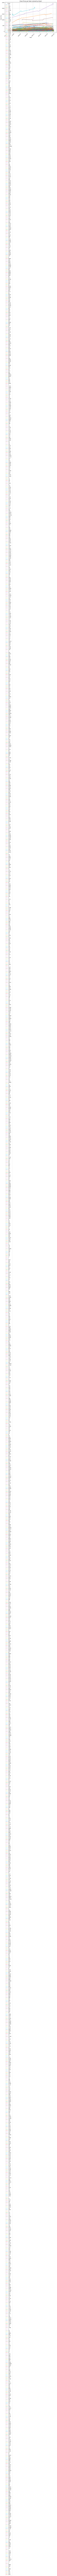

In [151]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(10, 6))
for ticker in test_df['ticker'].unique():
    ticker_data = test_df[test_df['ticker'] == ticker]
    plt.plot(ticker_data['Date'], ticker_data['Close'], label=ticker)

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Prices per Date (colored by ticker)')
plt.legend(title='Ticker')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

C:\Users\eoinp\AppData\Local\Temp\ipykernel_58828\409833681.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


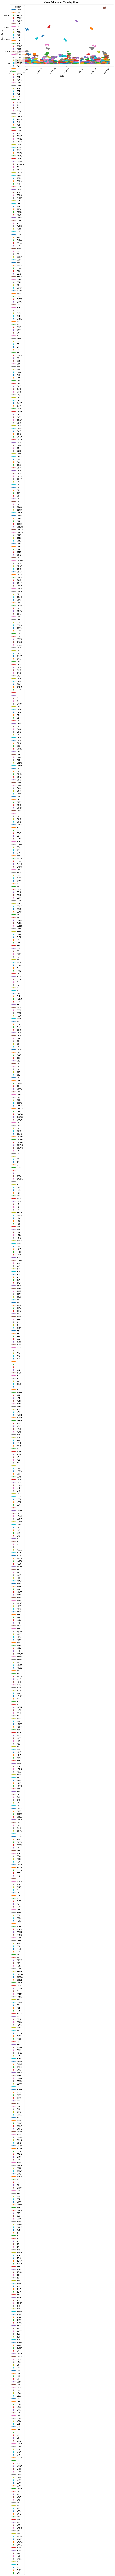

In [159]:
def plot_close_price_by_ticker(df):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Sort the dataframe by ticker and date
    df = df.sort_values(by=['ticker', 'Date'])
    
    # Loop through each ticker
    for ticker, group in df.groupby('ticker'):
        # Calculate the day difference between consecutive rows
        group['day_diff'] = group['Date'].diff().dt.days
        
        # Create a new block when there's a gap larger than 3 days (to allow for weekend breaks)
        group['block'] = (group['day_diff'] > 3).cumsum()
        
        # Plot each block separately, avoiding gaps
        for _, block in group.groupby('block'):
            ax.plot(block['Date'], block['Close'], label=ticker, marker='o')
    
    # Set labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')
    ax.set_title('Close Price Over Time by Ticker')
    
    # Show legend with tickers
    ax.legend(title="Ticker")
    
    # Display the plot
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Call the function to plot the data
plot_close_price_by_ticker(test_df)

In [1]:
import data_helper_v3 as dh3 

edt_dataset = dh3.process_EDT_json_to_dataframes("./data/EDT/evaluate_news.json")

C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'text': 'PLANO, Texas, Dec. 8, 2020 /PRNewswire/ --European Wax Center(EWC), the leading personal care franchise brand that offers expert wax services from certified specialists is proud to welcome a new Chief Financial Officer, Jennifer Vanderveldt. In the midst of European Wax Center\'s accelerated growth plan, Jennifer will lead the Accounting and FP&A teams to continue to widen growth and organizational initiatives. (PRNewsfoto/European Wax Center) "We are thrilled to have Jennifer join the European Wax Center team and partner with all functions to provide analytical and insightful leadership to support our accelerated growth, operational efficiency, the 360-guest experience, as well as our people and performance strategies," said David Berg, CEO of European Wax Center. Jennifer\'s background includes 20 years of leadership experience across strategy, finance, operations, marketing, analytics, and insights with multibillion-dollar retail and CPG brands, including Rubio\'s, Petco, 

In [161]:
edt_text, edt_ts = edt_dataset

In [162]:
edt_text

ticker                       date  \
0         MIK  2020-12-08 09:00:00-05:00   
1         DUK  2020-10-01 12:11:00-04:00   
2        PLRX  2020-10-05 08:00:00-04:00   
3              2021-01-18 02:30:00-05:00   
4        DISH  2021-02-22 06:05:00-05:00   
...       ...                        ...   
290894  GRUSF  2021-03-02 07:50:00-05:00   
290895    STT  2021-01-13 06:00:00-05:00   
290896         2020-12-14 08:08:00-05:00   
290897         2020-11-20 12:51:00-05:00   
290898    MMM  2021-01-26 10:45:00-05:00   

                                                    title  \
0       European Wax Center Welcomes Jennifer Vanderve...   
1       Duke Energy to host virtual Environmental, Soc...   
2       Pliant Therapeutics Appoints Mike Ouimette as ...   
3       Radiofrequency Ablation Devices Market Revenue...   
4       DISH Network reports fourth quarter, year-end ...   
...                                                   ...   
290894  Grown Rogue Reports Positive Adjusted EBITDA o...   
290895  Metropolitan Commercial Bank Appoints Ram Pupp...   
290896  Welldoc Submits 510(k) for Bolus and Premixed ...   
290897  $1.6 Billion Worldwide Variable Rate Technolog...   
290898  Outlook on the Non-woven Tape Global Market to...   

                                                     text      id  
0       PLANO, Texas, Dec. 8, 2020 /PRNewswire/ --Euro...       1  
1       CHARLOTTE, N.C., Oct. 1, 2020 /PRNewswire/ --D...       2  
2       SOUTH SAN FRANCISCO, Calif., Oct. 5, 2020 /PRN...       3  
3       NEW YORK, Jan. 18, 2021 /PRNewswire/ -- With a...       4  
4       ENGLEWOOD, Colo., Feb. 22, 2021 /PRNewswire/ -...       5  
...                                                   ...     ...  
290894  MEDFORD, Ore.--(BUSINESS WIRE)--Grown Rogue In...  290895  
290895  NEW YORK--(BUSINESS WIRE)--Metropolitan Commer...  290896  
290896  COLUMBIA, Md.--(BUSINESS WIRE)--Welldoc, a tra...  290897  
290897  DUBLIN--(BUSINESS WIRE)--The "Variable Rate Te...  290898  
290898  DUBLIN--(BUSINESS WIRE)--The "Non-woven Tape M...  290899  

[290899 rows x 5 columns]

In [163]:
edt_ts

ticker                       Date     Close      id
0         MIK  2020-12-08 19:11:00-05:00   12.8000       1
1         MIK  2020-12-09 18:45:00-05:00   12.4899       2
2         MIK  2020-12-10 19:35:00-05:00   13.0000       3
3         DUK  2020-10-01 16:02:00-04:00   90.0500       4
4         DUK  2020-10-02 19:58:00-04:00   91.0000       5
...       ...                        ...       ...     ...
319852    STT  2021-01-14 16:03:00-05:00   79.5800  319853
319853    STT  2021-01-15 16:42:00-05:00   77.1800  319854
319854    MMM  2021-01-26 19:53:00-05:00  175.3200  319855
319855    MMM  2021-01-27 19:07:00-05:00  184.0000  319856
319856    MMM  2021-01-28 19:51:00-05:00  183.0100  319857

[319857 rows x 4 columns]

In [1]:
import pandas as pd
import data_helper_v3 as dh3
stocknet_df = pd.read_csv("./data/stocknet/tweet/organised_tweet.csv")
stockemotion_df = pd.read_csv("./data/stock_emotions/tweet/processed_stockemo.csv")

edt_df = dh3.process_EDT_json_to_dataframes("./data/EDT/evaluate_news.json")

C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
stocknet_ticker_set = set(stocknet_df['ticker'].unique().tolist())
stockemotion_ticker_set = set(stockemotion_df['ticker'].unique().tolist())
edt_ticker_set = set(edt_df[0]['ticker'].unique().tolist())

In [14]:
result = edt_ticker_set.intersection(stockemotion_ticker_set.union(stocknet_ticker_set))
result

{'AAPL',
 'ABB',
 'ABBV',
 'ABNB',
 'AEP',
 'AGFS',
 'AMGN',
 'AMT',
 'AMZN',
 'BA',
 'BABA',
 'BAC',
 'BCH',
 'BHP',
 'BKNG',
 'BP',
 'BUD',
 'C',
 'CAT',
 'CCL',
 'CHL',
 'CHTR',
 'CMCSA',
 'CODI',
 'CSCO',
 'CVX',
 'D',
 'DHR',
 'DIS',
 'DUK',
 'EXC',
 'FB',
 'GD',
 'GE',
 'GOOG',
 'GOOGL',
 'HD',
 'HON',
 'HSBC',
 'IEP',
 'INTC',
 'JNJ',
 'JPM',
 'KO',
 'LMT',
 'LOW',
 'MA',
 'MCD',
 'MDT',
 'MMM',
 'MO',
 'MRK',
 'MSFT',
 'NEE',
 'NFLX',
 'NGG',
 'NKE',
 'NVDA',
 'NVS',
 'ORCL',
 'PCG',
 'PEP',
 'PFE',
 'PG',
 'PICO',
 'PM',
 'PPL',
 'PTR',
 'PYPL',
 'RDS-B',
 'REX',
 'SBUX',
 'SLB',
 'SNP',
 'SNY',
 'SO',
 'SPLP',
 'SRE',
 'T',
 'TM',
 'TOT',
 'TSLA',
 'TSM',
 'UL',
 'UN',
 'UNH',
 'UPS',
 'V',
 'VZ',
 'WFC',
 'WMT',
 'XOM'}

In [17]:
len(result)

92

In [21]:
file_path = "./data/tickers_selected/"

for ticker_set, filename in zip([stockemotion_df['ticker'].unique().tolist(), result, stocknet_df['ticker'].unique().tolist()], ['stockemotion.txt', 'edt.txt', 'stocknet.txt']):
    with open(file_path + filename, 'w') as file:
        for item in ticker_set:
            file.write(item + '\n')

In [20]:
stocknet_df['ticker'].unique().tolist()

87

In [ ]:
file_path = "./data/tickers_selected/stockemotion.txt"
with open(file_path, 'w') as file:
    for item in result:
        file.write(item + '\n')